In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# An implementation of https://towardsdatascience.com/bayesian-a-b-testing-with-python-the-easy-guide-d638f89e0b8a

from numba import jit
from math import lgamma

from scipy.stats import beta
from matplotlib import pyplot as plt
import numpy as np

In [3]:
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d): return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2): return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [5]:
#here we create the Beta functions for the two sets

def get_beta(population, positives, prior_negatives=0, prior_positives=0):
    _alpha = prior_positives
    _beta = prior_negatives
    a = positives + _alpha
    b = population - positives + _beta
    return beta(a, b)


def calc_beta_mode(a, b):
    '''this function calculate the mode (peak) of the Beta distribution'''
    return a/(a+b)

def plot_betas(betas, names, linf=0, lsup=0.01, with_mode=True):
    '''this function plots the Beta distribution'''
    x=np.linspace(linf,lsup, 1000)
    beta1, beta2 = betas
    win, lose = names 
    if beta1.mean() < beta2.mean(): win, lose = lose, win
    p = calc_prob_between(beta1, beta2)
    if win == names[1]: p = 1 - p
    title = f'{win} is better than {lose} with {p*100:2.1f}% probability'
    for f, name in zip(betas,names) :
        y=f.pdf(x) #this for calculate the value for the PDF at the specified x-points
        plt.plot(x,y, label=f"{name}, peak @ {f.mean():0.1E} $\pm$ {f.var():0.1E}")
        plt.yticks([])
    plt.title(title)
    plt.legend()
    plt.show()


from scipy.stats import gaussian_kde
import pandas as pd

def kde_from_experiments(exps, n=101):
    """Make a kernel density estimate for a PMF."""
    kde = gaussian_kde(exps,)
    qs = np.linspace(exps.min(), exps.max(), n)
    ps = kde.evaluate(qs)
    pmf = pd.Series(ps, qs)
    pmf /= pmf.sum()
    return pmf

def difference_credible_interval(kde, confidence_threshold):
    cdf = kde.cumsum()
    a_ = (1 - confidence_threshold) / 2
    ci = kde.index[(cdf > a_) & (cdf < 1 - a_)].values
    return ci

def plot_mc_differences(beta1, beta2, confidence_threshold=.8, N_experiments=100_000):
    exps_1, exps_2 = beta1.rvs(N_experiments), beta2.rvs(N_experiments)
    mc_diffs = exps_1 - exps_2
    #Notice that if you want to compute the uplifts, you should divide by either exps_1 or exps_2
    kde = kde_from_experiments(mc_diffs)
    ci = difference_credible_interval(kde, confidence_threshold)
    t = f'Difference in conversion rates'
    cit = f'{confidence_threshold * 100:.0f}% CI: [{ci.min():.4f}, {ci.max():.4f}]'

    kde.plot(label=t)
    pd.Series(0, ci).plot(c='black', linewidth=5, label=cit)
    plt.legend()
    return kde 
    
    

In [25]:
PRIOR_POSITIVES, PRIOR_NEGATIVES = 1, 9

CONVERSIONS_A = 42
POPULATION_A = 425

CONVERSIONS_B = 7
POPULATION_B = 61

beta_A = get_beta(POPULATION_A, CONVERSIONS_A, PRIOR_NEGATIVES, PRIOR_POSITIVES)
beta_B = get_beta(POPULATION_B, CONVERSIONS_B, PRIOR_NEGATIVES, PRIOR_POSITIVES)

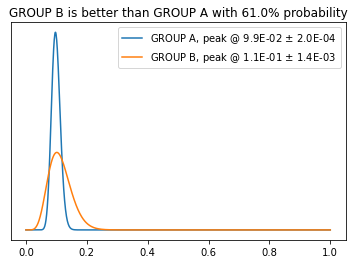

In [26]:
plot_betas([beta_A, beta_B], names=["GROUP A", "GROUP B"], lsup=1.)

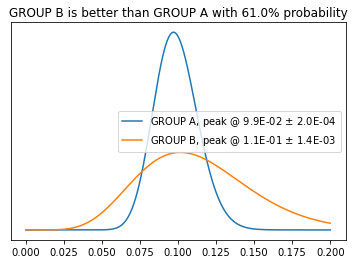

In [27]:
plot_betas([beta_A, beta_B], names=["GROUP A", "GROUP B"], lsup=.2)

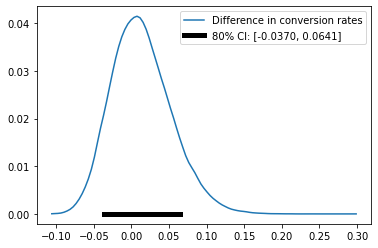

In [28]:
kde = plot_mc_differences(beta_B, beta_A, .8)